# Simple Gaussian Mixture Model

This notebook explores how to fit a Gaussian Mixture Model to a dataset using the SGD optimiser. The code for this has been retreived from the following [source](https://www.kernel-operations.io/keops/_auto_tutorials/gaussian_mixture/plot_gaussian_mixture.html).

In [11]:
import matplotlib.cm as cm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.nn import Module
from sklearn.datasets import make_blobs
from torch.nn.functional import softmax, log_softmax

from pykeops.torch import Vi, Vj, LazyTensor

In [12]:
features, clusters = make_blobs(n_samples = 100,
                  n_features = 2, 
                  centers = 1,
                  cluster_std = 0.4,
                  shuffle = True)

In [13]:
# Choose the storage place for our data : CPU (host) or GPU (device) memory.
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
torch.manual_seed(0)
N = 10000  # Number of samples
t = torch.linspace(0, 2 * np.pi, N + 1)[:-1]
x = torch.stack((0.5 + 0.4 * (t / 7) * t.cos(), 0.5 + 0.3 * t.sin()), 1)
x = x + 0.02 * torch.randn(x.shape)
x = x.type(dtype)
x.requires_grad = True

In [14]:
# Create a uniform grid on the unit square:
res = 200
ticks = np.linspace(0, 1, res + 1)[:-1] + 0.5 / res
X, Y = np.meshgrid(ticks, ticks)

grid = torch.from_numpy(np.vstack((X.ravel(), Y.ravel())).T).contiguous().type(dtype)

In [15]:
class GaussianMixture(Module):
    def __init__(self, M, sparsity=0, D=2):
        super(GaussianMixture, self).__init__()

        self.params = {}
        # We initialize our model with random blobs scattered across
        # the unit square, with a small-ish radius:
        self.mu = torch.rand(M, D).type(dtype)
        self.A = 15 * torch.ones(M, 1, 1) * torch.eye(D, D).view(1, D, D)
        self.A = (self.A).type(dtype).contiguous()
        self.w = torch.ones(M, 1).type(dtype)
        self.sparsity = sparsity
        self.mu.requires_grad, self.A.requires_grad, self.w.requires_grad = (
            True,
            True,
            True,
        )

    def update_covariances(self):
        """Computes the full covariance matrices from the model's parameters."""
        (M, D, _) = self.A.shape
        self.params["gamma"] = (torch.matmul(self.A, self.A.transpose(1, 2))).view(
            M, D * D
        ) / 2

    def covariances_determinants(self):
        """Computes the determinants of the covariance matrices.

        N.B.: PyTorch still doesn't support batched determinants, so we have to
              implement this formula by hand.
        """
        S = self.params["gamma"]
        if S.shape[1] == 2 * 2:
            dets = S[:, 0] * S[:, 3] - S[:, 1] * S[:, 2]
        else:
            raise NotImplementedError
        return dets.view(-1, 1)

    def weights(self):
        """Scalar factor in front of the exponential, in the density formula."""
        return softmax(self.w, 0) * self.covariances_determinants().sqrt()

    def weights_log(self):
        """Logarithm of the scalar factor, in front of the exponential."""
        return log_softmax(self.w, 0) + 0.5 * self.covariances_determinants().log()

    def likelihoods(self, sample):
        """Samples the density on a given point cloud."""
        self.update_covariances()
        return (
            -Vi(sample).weightedsqdist(Vj(self.mu), Vj(self.params["gamma"]))
        ).exp() @ self.weights()

    def log_likelihoods(self, sample):
        """Log-density, sampled on a given point cloud."""
        self.update_covariances()
        K_ij = -Vi(sample).weightedsqdist(Vj(self.mu), Vj(self.params["gamma"]))
        return K_ij.logsumexp(dim=1, weight=Vj(self.weights()))

    def neglog_likelihood(self, sample):
        """Returns -log(likelihood(sample)) up to an additive factor."""
        ll = self.log_likelihoods(sample)
        log_likelihood = torch.mean(ll)
        # N.B.: We add a custom sparsity prior, which promotes empty clusters
        #       through a soft, concave penalization on the class weights.
        return -log_likelihood + self.sparsity * softmax(self.w, 0).sqrt().mean()

    def get_sample(self, N):
        """Generates a sample of N points."""
        raise NotImplementedError()

    def plot(self, sample):
        """Displays the model."""
        plt.clf()
        # Heatmap:
        heatmap = self.likelihoods(grid)
        heatmap = (
            heatmap.view(res, res).data.cpu().numpy()
        )  # reshape as a "background" image

        scale = np.amax(np.abs(heatmap[:]))
        plt.imshow(
            -heatmap,
            interpolation="bilinear",
            origin="lower",
            vmin=-scale,
            vmax=scale,
            cmap=cm.RdBu,
            extent=(0, 1, 0, 1),
        )

        # Log-contours:
        log_heatmap = self.log_likelihoods(grid)
        log_heatmap = log_heatmap.view(res, res).data.cpu().numpy()

        scale = np.amax(np.abs(log_heatmap[:]))
        levels = np.linspace(-scale, scale, 41)

        plt.contour(
            log_heatmap,
            origin="lower",
            linewidths=1.0,
            colors="#C8A1A1",
            levels=levels,
            extent=(0, 1, 0, 1),
        )

        # Scatter plot of the dataset:
        xy = sample.data.cpu().numpy()
        plt.scatter(xy[:, 0], xy[:, 1], 100 / len(xy), color="k")

In [17]:
model = GaussianMixture(1, sparsity=20)
optimizer = torch.optim.Adam([model.A, model.w, model.mu], lr=0.1)
loss = np.zeros(100)

for it in range(100):
    optimizer.zero_grad()  # Reset the gradients (PyTorch syntax...).
    cost = model.neglog_likelihood(torch.from_numpy(features.astype('float32')))  # Cost to minimize.
    cost.backward()  # Backpropagate to compute the gradient.
    optimizer.step()
    loss[it] = cost.data.cpu().numpy()

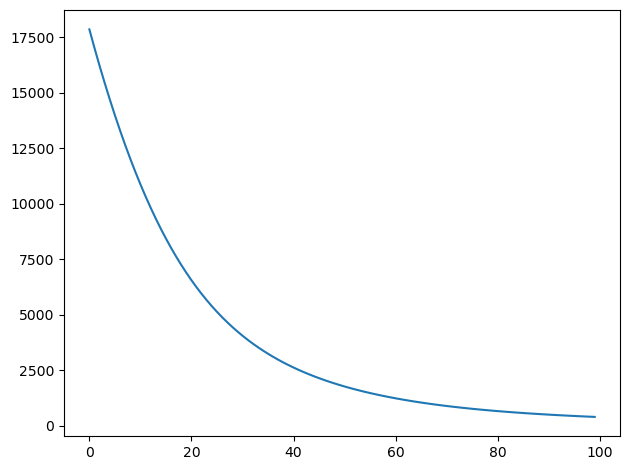

In [18]:
plt.figure()
plt.plot(loss)
plt.tight_layout()
plt.show()

In [19]:
model.mu

tensor([[ 3.5733, -5.1891]], requires_grad=True)

In [20]:
model.params['gamma']

tensor([[67.3459, 50.7717, 50.7717, 55.1427]], grad_fn=<DivBackward0>)

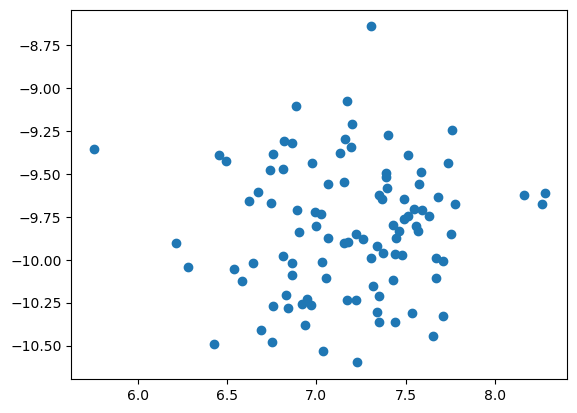

In [22]:
plt.scatter(features[:,0], features[:,1])
plt.show()